In [1]:
# required Python imports
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib import cm
# from types import SimpleNamespace

import ftir_funct as f
from scipy.optimize import minimize, dual_annealing

module FTIR v.2024.2.19 imported


# Testing different minimization algorithms

TODO

## Problem statement

As we will see, the most common algorithms do not always find the right solution. Let's start with a simple example.

In [2]:
# values for an euler orientation of [75 90 45] assuming transmission values of (90, 50, 20)
test1 = np.array([[36.5, 0.3, 90],
                  [45.9, 17.9, 90],
                  [51.9, 35.9, 90],
                  [51.9, 54.1, 90],
                  [45.9, 72.1, 90],
                  [36.3, 90.0, 90]])

Below, we will use the default minimisation algorithm used by the Scipy library according to the input we provide.

In [4]:
bounds = [(0, 90), (0, 180), (0, 90)]

result = minimize(fun=f.objective_function,
                  x0=(45, 90, 45),  # first guess
                  args=(test1, (90, 50, 20)),
                  bounds=bounds)

print(f'Solution: {np.around(result.x, 1)}, Expected: [75 90 45]')
print(' ')
print(result)

Solution: [ 89.9 101.2  45. ], Expected: [75 90 45]
 
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 69.22045525656965
        x: [ 8.990e+01  1.012e+02  4.498e+01]
      nit: 12
      jac: [ 9.332e-02  4.121e+00  8.043e+00]
     nfev: 356
     njev: 89
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


As we can see, although the algorithm has converged and found a solution, it is not the correct one. The reason for this is that there are multiple local minima in the space of Euler angles, i.e. the space defining the orientations, and this causes many of the most commonly used minimisation algorithms to fail. To see this, let's plot the minimisation values along the defined orientation space.

Text(0, 0.5, 'diff. T measured vs theoretical')

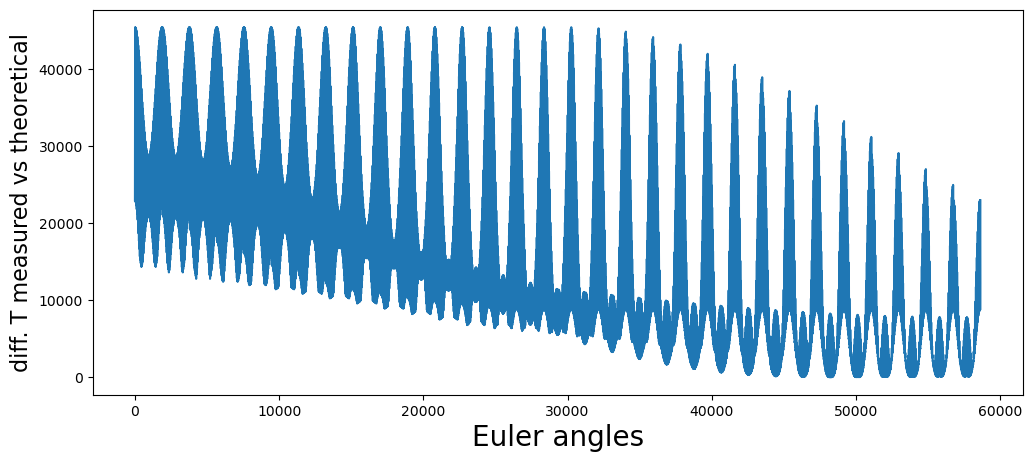

In [5]:
euler = f.explore_Euler_space(step=3)
diff = np.empty(euler.shape[0])

for index, euler_ang in enumerate(euler):
    val = f.objective_function(euler_ang, test1, params=(90, 50, 20))
    diff[index] = val

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(np.arange(len(diff)), diff)
ax.set_xlabel('Euler angles', fontsize=20)
ax.set_ylabel('diff. T measured vs theoretical', fontsize=16)


As can be seen, there are multiple local minima. A non-optimised solution to overcome this problem is to use a brute-force algorithm that explores the entire space of Euler angles with a defined precision (step size).

In [7]:
def brute_force2(step=3):
    
    euler = f.explore_Euler_space(step)
    diff = np.empty(euler.shape[0])

    for index, euler_ang in enumerate(euler):
        val = f.objective_function(euler_ang, test1, params=(90, 50, 20))
        diff[index] = val

    # euler[diff.argmin()] will return the euler triplet with the minimum diff
    # here we will return the 10 orientations with the smallest difference in
    # order from the smallest to the largest.
    indices_of_smallest_values = np.argsort(diff)[:10]

    for index in indices_of_smallest_values:
        print(f'diff: {diff[index]:.5f}; Euler angles: {euler[index]}')

    return None

# step=1 take minutes to find the solution!
brute_force2(1)

diff: 0.01713; Euler angles: [75 90 45]
diff: 0.13456; Euler angles: [75 87 44]
diff: 0.13456; Euler angles: [75 93 46]
diff: 0.45502; Euler angles: [75 94 46]
diff: 0.45503; Euler angles: [75 86 44]
diff: 0.50717; Euler angles: [75 91 45]
diff: 0.59315; Euler angles: [75 89 45]
diff: 0.81927; Euler angles: [75 88 44]
diff: 0.92878; Euler angles: [75 92 46]
diff: 1.26990; Euler angles: [75 85 43]


Of course, this strategy works, but it is inefficient and can take several minutes to find a solution for a resolution of 1 degree (step = 1). There are several algorithms and optimisation strategies to handle these situations more efficiently, among them: (i) Simulated Annealing, (ii) differential evolution (global optimisation), (iii) Particle Swarm Optimization (PSO), or (iv) basin-hopping algorithm among others. We will have to check them and find the best approach.

A first strategy is to use the same algorithm as before, but instead of starting with a single guess estimate, use multiple guess estimates evenly distributed over the space to be searched. This is what the ``find_orientation()`` function (implemented in ``ftir_funct.py`` file and imported here) does.

In [8]:
f.find_orientation(measurements=test1, params=(90, 50, 20), num_guesses=20)

Calculated orientation: [75. 90. 45.]


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.015350001877358901
        x: [ 7.499e+01  8.998e+01  4.499e+01]
      nit: 43
      jac: [-5.540e-02 -2.616e-04  3.590e-02]
     nfev: 584
     njev: 146
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

Here we can see that with 20 initial guesses this strategy takes a few seconds to find the correct solution. Let's also try the methods of differential evolution and dual annealing, both implemented in Scipy.

In [13]:
# this is the differential evolution method as implemented in ftir_funct.py
f.find_orientation_diffevol(measurements=test1, params=(90, 50, 20))

Calculated Orientation: [75.  89.9 45. ]


 message: Optimization terminated successfully.
 success: True
     fun: 0.015381027608712256
       x: [ 7.499e+01  8.992e+01  4.498e+01]
     nit: 44
    nfev: 2273
     jac: [ 1.277e-01  6.960e-02 -9.145e-02]

The differential method find a correct solution in less than a second.

In [14]:
# test using dual_annealing algorithm
bounds = [(0, 90), (0, 180), (0, 90)]

result = dual_annealing(func=f.objective_function,
                        bounds=bounds,
                        args=(test1, (90, 50, 20)),
                       )

print(np.around(result.x, 0))
result

[75. 90. 45.]


 message: ['Maximum number of iteration reached']
 success: True
  status: 0
     fun: 0.016239056236827268
       x: [ 7.498e+01  8.989e+01  4.497e+01]
     nit: 1000
    nfev: 6437
    njev: 109
    nhev: 0

It also found the correct orientation in less than two seconds.

In the next Jupyter notebook we will check which of these three algorithms provides correct solutions in the shortest time.

In [6]:
import sys
import matplotlib as mpl
from datetime import date    
today = date.today().isoformat()

print(f'Notebook tested in {today} using:')
print('Python', sys.version)
print('Matplotlib', mpl.__version__)

Notebook tested in 2024-02-19 using:
Python 3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:15:57) [MSC v.1916 64 bit (AMD64)]
Matplotlib 3.8.0
